# Blackjack Strategy Comparison2 (v3)
This jupyter notebook contains examples and code for using Game.results and the Pandas.Dataframe class to to do CS4 Blackjack strategy analysis. 

We suggest you work first work through `Blackjack_Strategy_Analysis1` notebook before you work through this notebook.  
#### Code Reuse ####
You are welcome to reuse the code found in either notebook inside of your own strategy analysis notebooks.  Too keep things tidy (and avoid duplicative code), we suggest copying the python functions that you want to use in more than one of your own notebooks into a file called `mynotebook.py `and then using the following command inside of each of your strategy analysis notebooks:

`from mynotebook.py import *` 




Note: If you're unsure about using notebooks, there are many tutorials and overviews available via Google.  Here is a more advanced [overview](http://arogozhnikov.github.io/2016/09/10/jupyter-features.html).

### Imports
One set of imports is usually located at the top of a notebook. 

In [1]:
# import all players from ai_simple3.py
from ai_simple3 import * 
# NOTE: you'll need to re-run this import to use any changes 
# made in that file or files it depends on.  If you can't
# see them, try restarting your notebook kernel.

# other imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# jupyter notebook specific setup
%matplotlib inline

/Users/Dan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Overview on comparing strategies
In the section below, we use the functions and techniques discussed in the`Blackjack_Strategy_Analysis` notebook to compare two strategies. 

In order for you to try out different comparisons, we define the following new AIPlayer strategies:   

* `AIPlayerGoodLuck` is `AIPlayerBadLuck`'s younger sibling, ever the optimist, this player assumes the dealer will always bust, so always stands.  
* `AIPlayerXray` uses the same strategy as `AIPlayerGoodLuck` except she can see the top card on the deck before each round begins (i.e. the dealers hole card), so can adjust her bet accordingly, she always just stands.

Here is step-by-step guide for getting the  most out of this notebook:
1. Review the player definitions below and then try running some player comparisons by adjusting the shared experimental parameters.  
2. Carefully read through the description on how each one of the comparisons operate.
3. Once you've sorted out the details on the differences between 'AIPlayerBadLuck' and 'AIPlayerGoodLuck', try comparing `AIGoodLuckPlayer` with itself.  Results from a pair of runs with a small number of rounds can easily lead one's thoughts in the wrong direction.  Even though the results may "look" quite different to you, it is much harder to fool the statistical comparison since it tests the hypothesis that you must see the current results more than 5% of the time.  This clearly illustrates why mean tests, and other statistical methods are critical when working with limited data.
5. Next try comparing 'AIPlayerXray' and 'AIPlayerGoodLuck'.  Can you find a better value for `other_bet`?  
6. Try refining your search for a good integer value of `other_bet` by running a `AIPlayerXray` against itself for a variety of values of `other_bet`.  
7. Try using fractional betting with `AIPlayerXray` by setting `other_bet` to various values in the interval $[0,1)$.  Look carefully at how well the mean comparisons test work (or don't work!) in this case.

Good luck and feel free to ask questions on Piazza!

In [2]:
class AIPlayerGoodLuck(AIPlayerBadLuck):
    """Player assumes the dealer will always bust, so always stands."""
    def next_move(self):
        return 's'

In [3]:
class AIPlayerXray(AIPlayerGoodLuck):
    """Adjusts bet based on dealer's hole card, otherwise always stands."""
    def __init__(self, bankroll, min_bet, shoe, other_bet=1):
        """The player adjusts it's bet to be either min_bet or 
        self.other_bet*self.min_bet (for other_bet>=1) and 
        other_bet*self.bankroll (for other_bet < 1) (when possible)."""
        super().__init__(bankroll, min_bet)
        self.shoe = shoe
        self.other_bet = other_bet

    def bet(self):
        if shoe.infinite: 
            state = random.getstate () # save random number generator state
            hole_card = shoe.deal(1)[0] # deal card
            random.setstate(state)  # reset random number generator state
        else:
            hole_card = self.shoe.cards[self.shoe.next_card] # peek ahead in list
        
        if hole_card.name in ['2','3','4','5','6']:
            if self.other_bet >= 1:
                b = self.min_bet * self.other_bet
            else:
                b = self.bankroll * self.other_bet
        else:
            b = self.min_bet
       
        b = min(self.bankroll,b)
        # print(hole_card.name, b)
        return b if b > self.min_bet else self.min_bet     
        

Below we define a runPlayer function that sets up and runs a Game using experimental parameters stored in the argument named pr.

In [4]:
def game2gdf(game):
    """
    Represents game.results in a Pandas DataFrame.
    The DataFrame gain column is updated to hold actual gains.
    Original game.results gain factors are available in the 
    DataFrame gain_factor column.
    Returns the dataframe.
    """
    df = pd.DataFrame(game.results)
    df['type'].astype('category', copy=False)
    df['shuffle'].astype('category', copy=False)
    # store gain factors in column "gain factor" 
    df['gain_factor'] = df['gain']
    # store actual gains in column "gain"
    df['gain'] = df['gain']*df['bet'] 
    df = df.drop(['EG'], axis=1)
    return df

def runPlayer(p, pr):
    """Creates and runs a game using Player p and and experimental 
    parameters pr. After the run it stores a pandas dataframe version of the game.results as game.df  
    Returns the game."""
    print('\nSetting up a game with', p.__class__.__name__)
    d = DealerH17()
    game = Game(d, p, pr.shoe, pr.num_round, print_n=pr.print_n)
    game.playerClass = p.__class__.__name__ # Name of AIPlauer class that was run
    print('Starting..')
    game.run()
    print('Finished')
    game.summary()
    game.df = game2gdf(game)
    return game

### Shared experimental parameters
Here is a copy of the share experimental parameters, each one is associated the variable named pr (which is shorthand for parameters).  Binding all the parameters to a single variable makes it easy to use multiple parameter sets. 

As before, remember to re-run this cell every time you make an adjustment to the parameters.

In [5]:
class ExperimentalParams():
    pass

pr = ExperimentalParams()

## shared experimental parameters ##

pr.bankroll = 50000    # starting player balance
pr.min_bet = 1         # min allowed bet
pr.num_deck = 2        # number decks in shoe
pr.inf_deck = True     # True if using infinite deck
pr.seed = None         # seed value to assign before every run
pr.num_round = 20      # number rounds to play
#pr.num_round = 10**2
pr.num_round = 10**3
#pr.num_round = 10**4
#pr.num_round = 10**5
#pr.num_round = 10**6

## other parameters ##
# have Game print a reasonable number of rounds:
pr.print_n = 1 if pr.num_round <= 20 else max(1, math.ceil(pr.num_round/math.log2(pr.num_round)))
pr.print_n = 0         # suppess round printing entirely

### Run multiple experiments

In [6]:
### initialize shoe
random.seed(pr.seed)
pr.shoe = Shoe(pr.num_deck, infinite=pr.inf_deck) # create shoe here to allow peeking

### initialize the players to compare
p1 = AIPlayerBadLuck(pr.bankroll, pr.min_bet)
p2 = AIPlayerGoodLuck(pr.bankroll, pr.min_bet)
#p1 = AIPlayerXray(pr.bankroll, pr.min_bet, pr.shoe, 10)

### run the games
g1 = runPlayer(p1, pr)
g2 = runPlayer(p2, pr)

games = [g1, g2] # list of game.runs


Setting up a game with AIPlayerBadLuck
Starting..
Finished
Total Rounds 1000 [Wins: 362 Losses: 601 Ties: 37]
tot_bet = 1000.0 tot_won = 802.8000000000004 (won-bet)=-197.1999999999996
E(won-bet) = -0.1971999999999996 (won-bet)/tb = -0.1971999999999996 EG = -0.1972000000000001
EG 95% CI = (-0.2607408053102449, -0.13365919468975507)

Setting up a game with AIPlayerGoodLuck
Starting..
Finished
Total Rounds 1000 [Wins: 394 Losses: 565 Ties: 41]
tot_bet = 1000.0 tot_won = 867.0000000000007 (won-bet)=-132.99999999999932
E(won-bet) = -0.1329999999999993 (won-bet)/tb = -0.1329999999999993 EG = -0.13299999999999995
EG 95% CI = (-0.19672219984902845, -0.06927780015097158)


### Data sanity check
It is a good idea to use the pandas .describe() method as a quick way to verify each experimental works as expected. 
If a player goes bankrupt the simulation will stop early.  Looking at the statistics presented by the .decribe() method is one way to spot this type of problem.

Notice how easy it is to iterate through game runs.

In [7]:
for g in games:
    print(g.playerClass + ':') 
    print(g1.df.describe())
    print()

AIPlayerBadLuck:
             round     bet         gain  final_bankroll  gain_factor
count  1000.000000  1000.0  1000.000000     1000.000000  1000.000000
mean    500.500000     1.0    -0.197200    49903.178450    -0.197200
std     288.819436     0.0     1.023949       57.513079     1.023949
min       1.000000     1.0    -1.000000    49802.800000    -1.000000
25%     250.750000     1.0    -1.000000    49847.450000    -1.000000
50%     500.500000     1.0    -1.000000    49913.825000    -1.000000
75%     750.250000     1.0     1.000000    49947.600000     1.000000
max    1000.000000     1.0     1.950000    50004.950000     1.950000

AIPlayerGoodLuck:
             round     bet         gain  final_bankroll  gain_factor
count  1000.000000  1000.0  1000.000000     1000.000000  1000.000000
mean    500.500000     1.0    -0.197200    49903.178450    -0.197200
std     288.819436     0.0     1.023949       57.513079     1.023949
min       1.000000     1.0    -1.000000    49802.800000    -1.00000

## Equity Curves
Below we plot the **equity curves** from two strategies.  When the number of rounds is small the results are generally not noisy, and in many cases can be misleading.  Both visually and statistically.  At some point you should be sure and try running this notebook with pr.num_round set to a variety of values.  

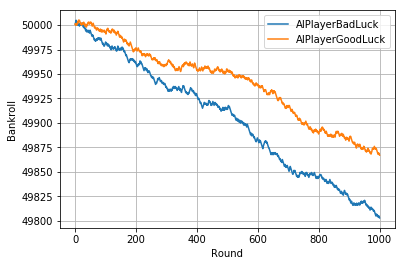

In [8]:
### compare equity curves
fig,ax = plt.subplots()
# ax.set_yscale('log')  # Can use log scale for crazy moneymakers, 
                        # not needed w/GoodLuck, BadLuck.
for g in games:
    ax.plot(g.df[['final_bankroll']], label=g.playerClass)
ax.set_xlabel("Round")
ax.set_ylabel("Bankroll")
ax.legend(loc='best')
ax.grid('on')

### Comparison of Means
Comparing whether or not two [data samples](https://en.wikipedia.org/wiki/Sample_(statistics)) come from the same underlying population distribution or two different population distributions is an important problem in most scientific disciplines.  One approach to doing this is to compute the means of both samples and then do a statistical test, based on the variability in each sample set collected, to ascertain if it is likely that the two means observed could have been produced by a single distribution, assuming that it had as much variability as was observed in the two sample sets.  

This question comes up in CS4 Blackjack in the context of strategy comparison.  Each run of strategy can be viewed as an experiment, the data collected at each round represents one sample point (so for example, a one million round run will generate one million sample points, assuming the player didn't go bankrupt).  

When comparing strategies, the mean player gain per round is the primary quantity of interest.  When are two strategies the same? Since the data is noisy, the means will rarely if ever be equal to one another, even for two runs of the same strategy. When do they differ? And when they differ, which one is better? The equity curves, particular over short runs, clearly show a lot variability can occur.  Using statistical tests cuts through this noise, and allows one to ascertain with a high degree of confidence answers to these questions.

The means comparison test used below is very simple and also very intuitive. It uses the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error) to define 95% confidence intervals for each sample, and then checks for overlap between those intervals.  A couple of benefits to this approach is that it works fine even for un-even sample sizes, and doesn't require the distributions being compared to have the same variance.  A couple of drawbacks, shared by most of the common methods for comparing means, are that it assumes the distribution of possible sample means from both experiments is normally distributed and that the individual samples are *statistically independent* of one another.  This means round results shouldn't depend on one another.

These assumptions are perfect when using an infinite deck.  When one is using a finite deck, the samples are not quite independent, because the cards are no longer being dealt with replacement.  However, over the course of many rounds and shuffles, the observed differences between the exact case and the independent case are slight. 

**First, Important Caveats:**  Where these assumption may really fall apart is when fractional bankroll betting is employed(as in AIPlayerXray, with other_count in $(0,1)$.  Here the current gains may depend heavily on the past, so the notion of independent rounds is now fully suspect.

**Second, Important Caveat:**
The comparison of `EGgivenBJ` and `EGgivenHS` across strategies **only** makes sense when the probabilities of `BJ` and and `HS` are the same in both strategies.  If they differ, the only way to make to avoid an apples to oranges comparison is via `PoBJ\*EGgivenBJ` and `PoHS\*EGgivenHS`. See `Q1` and `A1` in the other notebook. Fortunately, for non-peeking (cheating) strategies we can assume this invariant holds.

**Third, Important Caveat:**
In order to "zoom in", on your hit stand strategy's performance you can construct other sets of event types to focus on (e.g., ignore D_Bust and focus on P_Bust, P_Lost and P_won). However, if you do, be careful of the points raised in in the second caveat above.

### The Mean Comparison Test
The code below performs a difference in expected gains test on both the overall case and for the HS and BJ cases. These tests and given what you know about each strategy's construction provide a statistical good window on their relative performance. 

In [15]:
def estimate_EG_CI(gdf, prnt=None):
    """Returns EG and 95% CI estimates (EG, CI_low, CI_high)
    Prints results using EGgiven{prnt} = when prnt is set to a string"""
    m = gdf['gain'].mean()
    sem = gdf['gain'].std()/(gdf['gain'].count())**.5
    c_low = m-1.96*sem
    c_high = m+1.96*sem
    if prnt is not None: print('EGgiven{} = {:3.6f}, 95% confidence interval = [{:3.4f},{:3.4f})'.format(prnt, m, c_low, c_high))
    return (m, c_low, c_high)

BJ = ['D_BJ', 'P_BJ', 'PD_BJ']
HS = ['P_Bust', 'D_Bust', 'P_Won', 'P_Lost', 'PD_Draw']
ALL = BJ + HS
name_set = (('ALL',ALL), ('BJ', BJ), ('HS', HS))

print(g1.playerClass+ '(A) -vs- '+ g2.playerClass + '(B)')
for name,set in name_set:
    eg1 = estimate_EG_CI(g1.df[g1.df['type'].isin(set)], prnt=name)
    eg2 = estimate_EG_CI(g2.df[g2.df['type'].isin(set)], prnt=name)
    if eg1[2] < eg2[1]:
        print('A < B: *A is LESS*')
    elif eg2[2] < eg1[1]:
        print('A > B: *A is MORE*')
    else: 
        print('A = B: *A EQUAL B*')

AIPlayerBadLuck(A) -vs- AIPlayerGoodLuck(B)
EGgivenALL = -0.197200, 95% confidence interval = [-0.2607,-0.1337)
EGgivenALL = -0.133000, 95% confidence interval = [-0.1966,-0.0694)
A = B *A EQUAL B*
EGgivenBJ = 0.486364, 95% confidence interval = [0.1780,0.7947)
EGgivenBJ = 0.463415, 95% confidence interval = [0.1457,0.7811)
A = B *A EQUAL B*
EGgivenHS = -0.263158, 95% confidence interval = [-0.3245,-0.2019)
EGgivenHS = -0.186275, 95% confidence interval = [-0.2485,-0.1241)
A = B *A EQUAL B*


### Paired Outcome Counts
Looking at the counts for various outcome types in the strategies can help you understand if they are working correctly.

* Q3: Perform a run comparing `AIPlayerBadLuck` with `AIPlayerGoodLuck`. Explain why the `P_Bust` counts appear as they do in the plot below.

         AIPlayerBadLuck  AIPlayerGoodLuck
P_Bust               429               0.0
D_Bust               172             271.0
P_Won                146              83.0
P_Lost               129             525.0
P_BJ                  44              40.0
D_BJ                  43              40.0
PD_Draw               36              39.0
PD_BJ                  1               2.0


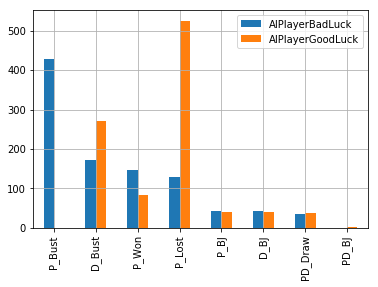

In [14]:
df = pd.DataFrame()
for i, g in enumerate(games):
    df[g.playerClass]=g.df['type'].value_counts()
df.fillna(0, inplace=True)
df.plot(kind='bar',grid=True)
# check
print(df)

### Paired Outcome Probabilitiy Estimates
Normalizing the observed counts so that they sum to 1 converts them into probability estimates for each outcome.  
* Q4: Using an `AIPlayerBadLuck` and `AIPlayerGoodLuck` run, and the plot below explain why `AIPlayerGoodLuck` performs better than `AIPlayerBadLuck`, even though it has a huge P_Lost probability compared to that of  `AIPlayerBadLuck`.   

         AIPlayerBadLuck  AIPlayerGoodLuck
P_Bust             0.429             0.000
D_Bust             0.172             0.271
P_Won              0.146             0.083
P_Lost             0.129             0.525
P_BJ               0.044             0.040
D_BJ               0.043             0.040
PD_Draw            0.036             0.039
PD_BJ              0.001             0.002


AIPlayerBadLuck     1.0
AIPlayerGoodLuck    1.0
dtype: float64

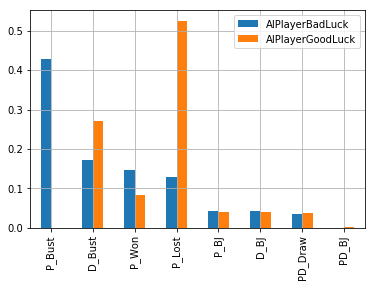

In [13]:
P = pd.DataFrame()
for i, g in enumerate(games):
    P[g.playerClass]=(g.df['type'].value_counts()/len(g.df))
P.fillna(0, inplace=True)
P.plot(kind='bar',grid=True)
# check:
print(P)
P.sum()